# Entity Resolution & Data Quality — Veridion Presales POC

This notebook resolves each input company to its best real-world match using Veridion's candidate data, then flags anything that needs a human second look.

**Structure**
1. Setup & data loading
2. Exploratory data analysis
3. Input data quality check
4. Candidate data quality check
5. Normalization helpers
6. Scoring & entity resolution
7. Results & review queue


## Libraries

In [68]:
#!pip install country_converter thefuzz[speedup]
#!pip install pycountry
#!pip install thefuzz[speedup]

In [69]:
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from collections import Counter
from datetime import timezone
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Arial'


## Data Loading & First Look

Each row in the raw file is one *candidate match* for an input company. We have up to 5 candidates per input, so we expect ~5× more rows than unique companies.


In [70]:
df = pd.read_csv('presales_data_sample.csv', low_memory=False)
print(f'Rows: {len(df):,}  |  Unique input companies: {df['input_row_key'].nunique():,}')

Rows: 2,951  |  Unique input companies: 592


In [71]:
df.head(5)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,twitter_url,instagram_url,linkedin_url,ios_app_url,android_app_url,youtube_url,tiktok_url,technologies,created_at,last_updated_at
0,0,24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED,PK,Pakistan,Sindh,Karachi,NaN,NaN,NaN,26e22210-93e5-11eb-b997-8dd98d09cf25,...,NaN,NaN,http://www.linkedin.com/company/mnet-services-...,NaN,NaN,NaN,NaN,web servers: apache http server - 2 | javascri...,2020-02-25T14:47:51.000Z,2024-11-29T04:18:00.109Z
1,0,24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED,PK,Pakistan,Sindh,Karachi,NaN,NaN,NaN,01004641-1dd8-11ef-9268-316fc8e174dd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-29T16:24:11.019Z,2025-04-20T15:03:24.026Z
2,0,24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED,PK,Pakistan,Sindh,Karachi,NaN,NaN,NaN,8266efc1-13e7-11ec-aa14-7bf90e1e10f1,...,https://twitter.com/Network24seven%20,NaN,https://www.linkedin.com/company/51633612%20%20,NaN,NaN,NaN,NaN,NaN,2021-09-12T05:28:48.000Z,2025-03-18T23:08:37.059Z
3,0,24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED,PK,Pakistan,Sindh,Karachi,NaN,NaN,NaN,0183f0b2-93e5-11eb-be5a-4f810ab55f2e,...,https://twitter.com/emeriosoft,NaN,https://www.linkedin.com/company/emeriosoft,NaN,NaN,NaN,NaN,miscellaneous: popper | maps: google maps | pr...,2020-05-03T12:33:22.000Z,2025-03-31T16:16:58.462Z
4,0,24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED,PK,Pakistan,Sindh,Karachi,NaN,NaN,NaN,87bb7cde-93e4-11eb-8474-3bbe2d07207d,...,https://twitter.com/AsiaticPR,https://www.instagram.com/asiaticpublicrelations/,https://www.linkedin.com/company/asiaticpublic...,NaN,NaN,https://www.youtube.com/channel/UClKgHvHIuOu4K...,NaN,miscellaneous: babel | javascript libraries: c...,2020-02-19T03:58:25.000Z,2024-11-25T11:35:47.963Z


## Candidate count per input

Most inputs should have 5 candidates. Inputs with fewer are worth a closer look — 
it might mean the engine struggled to find matches, which makes resolution harder.


In [72]:
per_key = df.groupby('input_row_key').size()

print('Candidate counts:')
print(per_key.value_counts().sort_index().to_string())
short = per_key[per_key < 5]
print(f'\n{len(short)} input(s) have fewer than 5 candidates — flagged for manual review')


Candidate counts:
2      2
3      1
4      1
5    588

4 input(s) have fewer than 5 candidates — flagged for manual review


In [73]:
# inspect the low ones
df[df['input_row_key'].isin(short.index)]


,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,twitter_url,instagram_url,linkedin_url,ios_app_url,android_app_url,youtube_url,tiktok_url,technologies,created_at,last_updated_at
1365,344,NEMTILMELD.DK ApS,DK,Denmark,North Denmark Region,Nørresundby,9400,Strømmen,6,2aa23446-e761-11ec-b439-759fbd5b5f85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ui frameworks: bootstrap | miscellaneous: popp...,2022-06-08T18:40:23.000Z,2024-06-30T10:11:43.000Z
1366,344,NEMTILMELD.DK ApS,DK,Denmark,North Denmark Region,Nørresundby,9400,Strømmen,6,0cf1a919-93e5-11eb-86dd-ffbd1b53140e,...,NaN,NaN,https://www.linkedin.com/company/nemtilmeld,NaN,NaN,NaN,NaN,analytics: facebook custom audiences | analyti...,2019-11-24T00:46:25.000Z,2025-03-26T01:03:41.790Z
1632,393,PELATRO LIMITED,GB,United Kingdom,England,London,SE26 4NG,Mount Gardens,Oak House,8bcce5c1-8aa9-11ec-aad9-15d72f2b9d1a,...,NaN,https://www.instagram.com/pelatro_social/,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-02T14:36:31.000Z,2025-04-17T01:50:42.568Z
1633,393,PELATRO LIMITED,GB,United Kingdom,England,London,SE26 4NG,Mount Gardens,Oak House,25f18078-93e5-11eb-8859-29e7c34dee35,...,https://twitter.com/aspectshistory,https://www.instagram.com/aspectsofhistory/,http://www.linkedin.com/company/aspectsofhistory,NaN,NaN,NaN,NaN,web servers: ibm websphere application server ...,2020-07-27T16:08:48.000Z,2025-04-03T11:24:06.189Z
1634,393,PELATRO LIMITED,GB,United Kingdom,England,London,SE26 4NG,Mount Gardens,Oak House,68d58f01-b94d-11ed-b9f5-df9417966c48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript libraries: core-js | ui frameworks:...,2023-03-02T21:08:15.000Z,2024-10-31T07:19:34.000Z
1635,393,PELATRO LIMITED,GB,United Kingdom,England,London,SE26 4NG,Mount Gardens,Oak House,b398bc50-93e4-11eb-be3a-7f925cb94351,...,https://twitter.com/pelatro,https://www.instagram.com/pelatro_social/,https://www.linkedin.com/company/pelatro,NaN,NaN,NaN,NaN,cms: wordpress - 6.3.2 | javascript frameworks...,2019-11-24T03:31:43.000Z,2025-02-20T21:55:15.009Z
1811,425,REVEALCX LLC,US,United States,Delaware,New Castle,NaN,NaN,NaN,168fa5a3-20d1-11ee-955b-359ace42ebb8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript libraries: core-js | miscellaneous:...,2023-07-12T15:32:20.000Z,2024-06-05T23:23:16.000Z
1812,425,REVEALCX LLC,US,United States,Delaware,New Castle,NaN,NaN,NaN,369fd921-9bc9-11ec-9ba8-7f83afda027b,...,NaN,NaN,http://www.linkedin.com/company/revealcx,NaN,NaN,NaN,NaN,ssl/tls certificate authorities: aws certifica...,2022-02-08T23:57:40.000Z,2024-11-24T02:38:11.210Z
1828,429,RTTD LTD,GB,United Kingdom,England,London,W1B 3HH,Regent Street,207,b9b2d1d2-9a09-11ec-9faf-49592d66acb7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,javascript libraries: webp | web servers: empa...,2022-02-24T00:17:53.000Z,2024-07-23T23:10:09.000Z
1829,429,RTTD LTD,GB,United Kingdom,England,London,W1B 3HH,Regent Street,207,c4604bd0-9a80-11ed-b4fe-8df6feb9e74c,...,NaN,NaN,http://www.linkedin.com/company/rttd-studio,NaN,NaN,NaN,NaN,NaN,2023-01-22T18:14:55.522Z,2024-11-15T08:03:05.964Z


### Column inventory

Split columns into *input* (what the client provided) vs *candidate*.

In [110]:
in_cols  = [c for c in df.columns if c.startswith('input')]
out_cols = [c for c in df.columns if not c.startswith('input') and c != 'veridion_id']

print(f'{len(in_cols)} input columns:  {in_cols}')
print(f'\n{len(out_cols)} candidate columns (first 15): {out_cols[:15]}')


9 input columns:  ['input_row_key', 'input_company_name', 'input_main_country_code', 'input_main_country', 'input_main_region', 'input_main_city', 'input_main_postcode', 'input_main_street', 'input_main_street_number']

68 candidate columns (first 15): ['company_name', 'company_legal_names', 'company_commercial_names', 'main_country_code', 'main_country', 'main_region', 'main_city', 'main_postcode', 'main_street', 'main_street_number', 'main_latitude', 'main_longitude', 'locations', 'num_locations', 'company_type']


## 3. EDA

Here, I take a closer look at the data, looking to visualize some insightful plots or find any quick outliers/problems


### 3.1 Null values

First thing that comes to mind is to check for null variants, as they very often appear in merged data from multiple sources.

In [75]:
nullz = {'null', 'none', 'n/a', 'na', 'nan', '#n/a', 'n.a.', '-', '--', 'nil'}

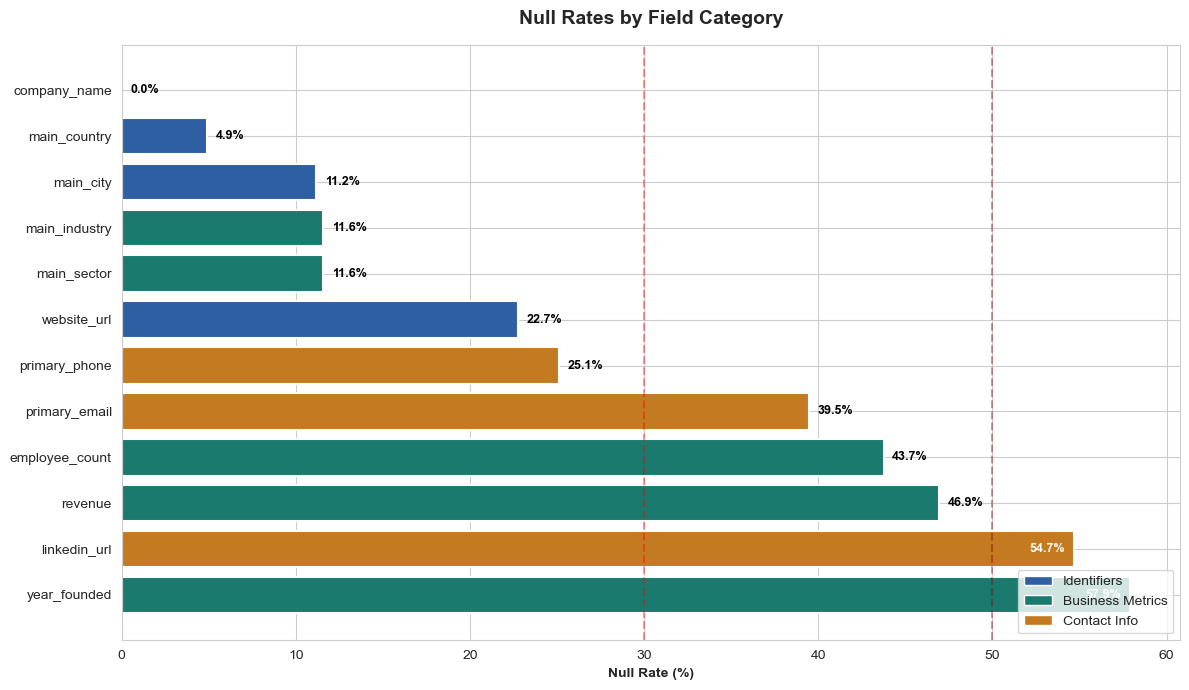

In [105]:
#barplot for null fields by category
id_fields  = ['company_name', 'main_country', 'main_city', 'website_url']
biz_fields = ['revenue', 'employee_count', 'year_founded', 'main_sector', 'main_industry']
con_fields = ['primary_phone', 'primary_email', 'linkedin_url']

palette = {'id': '#2E5FA3', 'biz': '#1A7A6E', 'con': '#C47A20'}

fields, rates, colors = [], [], []
for f in id_fields:  fields.append(f); rates.append(df[f].isna().mean()*100); colors.append(palette['id'])
for f in biz_fields: fields.append(f); rates.append(df[f].isna().mean()*100); colors.append(palette['biz'])
for f in con_fields: fields.append(f); rates.append(df[f].isna().mean()*100); colors.append(palette['con'])

order = sorted(zip(fields, rates, colors), key=lambda x: x[1], reverse=True)
fields, rates, colors = zip(*order)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(fields, rates, color=colors, edgecolor='white', linewidth=1.5)
for bar, pct in zip(bars, rates):
    w = bar.get_width()
    ax.text(w + 0.5 if w < 50 else w - 0.5, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', ha='left' if w < 50 else 'right',
            va='center', fontsize=9, fontweight='bold',
            color='black' if w < 50 else 'white')
ax.axvline(30, color='red',     linestyle='--', alpha=0.4, label='30% threshold')
ax.axvline(50, color='darkred', linestyle='--', alpha=0.4, label='50% threshold')
ax.set_xlabel('Null Rate (%)', fontweight='bold')
ax.set_title('Null Rates by Field Category', fontsize=14, fontweight='bold', pad=15)
legend_els = [Patch(facecolor=palette['id'],  label='Identifiers'),
               Patch(facecolor=palette['biz'], label='Business Metrics'),
               Patch(facecolor=palette['con'], label='Contact Info')]
ax.legend(handles=legend_els, loc='lower right')
plt.tight_layout()
#plt.savefig('null_fields_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

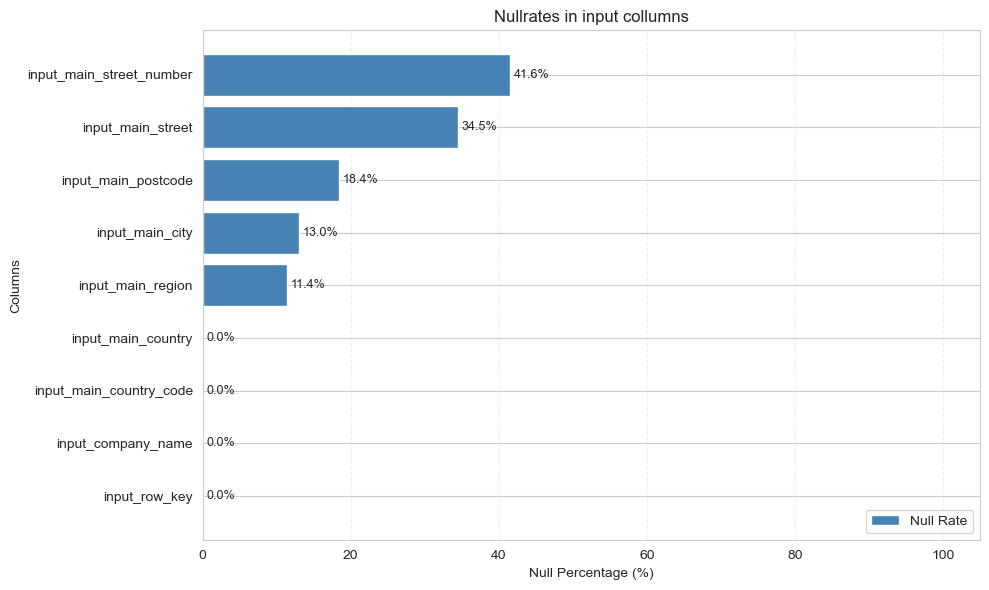

In [113]:
# Calculate null percentages for your columns
null_pcts = []
for f in in_cols:
    null_pct = df[f].isna().mean() * 100
    null_pcts.append({'column': f, 'null_percent': null_pct})

# Create DataFrame and sort by null percentage (ascending = least empty first)
null_df = pd.DataFrame(null_pcts)
null_df_sorted = null_df.sort_values('null_percent', ascending=True)

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, max(6, len(in_cols)*0.3)))

# Create bars
bars = ax.barh(null_df_sorted['column'], null_df_sorted['null_percent'], color='steelblue')

# Add percentage labels on the bars
for i, (bar, pct) in enumerate(zip(bars, null_df_sorted['null_percent'])):
    width = bar.get_width()
    # Place text at end of bar with 1 decimal place
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', ha='left', fontsize=9)

# Customize the plot
ax.set_xlabel('Null Percentage (%)')
ax.set_ylabel('Columns')
ax.set_title('Nullrates in input collumns')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add a legend (even though it's a single color, for completeness)
ax.legend(['Null Rate'], loc='lower right')

# Set x-axis limit to 100% with a little buffer for labels
ax.set_xlim(0, 105)

plt.tight_layout()
#plt.savefig('input_nulls.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Data freshness

Old data can be a hazard, as suppliers can dissapear, change names/locations etc. I'm gonna flag anything not updated since **2023**.

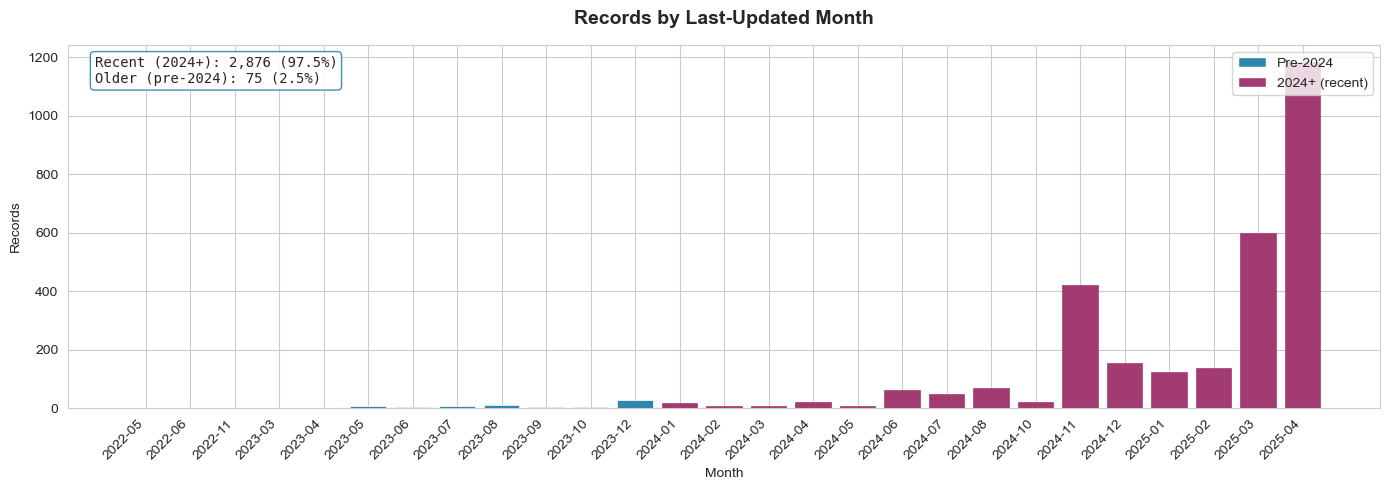

In [114]:
df['updated_at'] = pd.to_datetime(df['last_updated_at'], errors='coerce', utc=True)
df['ym']         = df['updated_at'].dt.to_period('M').astype(str)

monthly = df['ym'].value_counts().sort_index()
recent  = monthly[monthly.index >= '2024-01'].sum()
old     = monthly[monthly.index <  '2024-01'].sum()

fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(monthly.index, monthly.values, color='#2E86AB', edgecolor='white', linewidth=0.5)
for i, m in enumerate(monthly.index):
    if m >= '2024-01': bars[i].set_color('#A23B72')
ax.set_title('Records by Last-Updated Month', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Month'); ax.set_ylabel('Records')
plt.xticks(rotation=45, ha='right')
summary = (f'Recent (2024+): {recent:,} ({recent/len(df)*100:.1f}%)\n'
           f'Older (pre-2024): {old:,} ({old/len(df)*100:.1f}%)')
ax.text(0.02, 0.97, summary, transform=ax.transAxes, va='top',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='#2E86AB', alpha=0.9),
        fontsize=10, fontfamily='monospace')
legend_els = [Patch(facecolor='#2E86AB', label='Pre-2024'), Patch(facecolor='#A23B72', label='2024+ (recent)')]
ax.legend(handles=legend_els, loc='upper right')
plt.tight_layout()
#plt.savefig('fresness.png', dpi=300, bbox_inches='tight')
plt.show()


### 3.4 Industries

Quick look at what sectors are represented.

In [78]:
print('Top sectors:')
print(df['main_sector'].value_counts().head(12).to_string())
print('\nTop industries:')
print(df['main_industry'].value_counts().head(12).to_string())


Top sectors:
main_sector
IT&C Services                          700
Finance & Insurance                    207
Other Professional Services            204
Advertising & Marketing                156
Electronics & Appliances               118
Transport & Warehousing                 90
Health Care & Social Assistance         79
Other Capital Goods                     78
Other Consumer Services                 78
Construction                            75
Publishers & Media Companies            68
Architecture & Engineering Services     68

Top industries:
main_industry
Software & IT Services               352
Telecommunication Services           348
Marketing & Advertising Agencies     123
Electrical & Electronic Equipment     80
Business Consulting                   74
Investment Firms & Consultants        54
Banks & Financial Services            53
Insurance                             52
Accountants & Tax Services            48
Freight Transport                     48
HR Services       

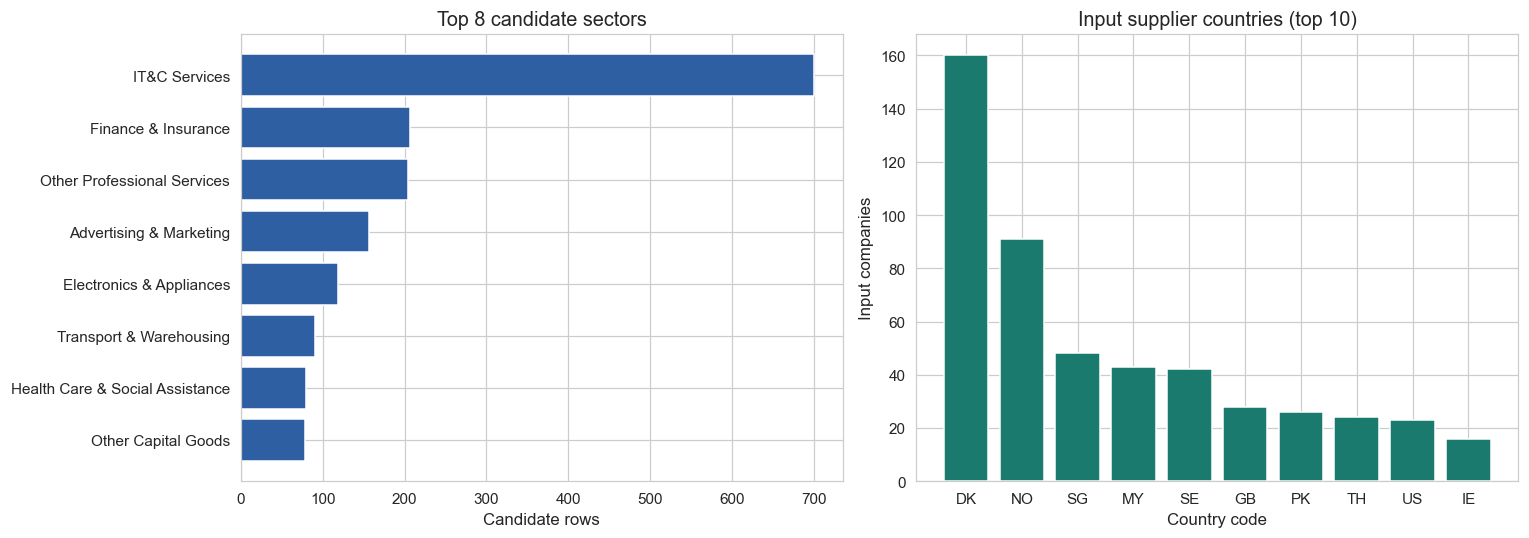

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: sector
sector_top = df["main_sector"].value_counts().head(8)
axes[0].barh(sector_top.index[::-1], sector_top.values[::-1],
             color=PALETTE["accent"])
axes[0].set_title("Top 8 candidate sectors")
axes[0].set_xlabel("Candidate rows")

# Right: input country
cc_top = companies["input_main_country_code"].value_counts().head(10)
axes[1].bar(cc_top.index, cc_top.values, color="#1A7A6E", edgecolor="white")
axes[1].set_title("Input supplier countries (top 10)")
axes[1].set_xlabel("Country code")
axes[1].set_ylabel("Input companies")

plt.tight_layout()
plt.savefig('sectors_and_countries.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Input Data Quality

Before matching, let's audit the data the *client* sent us. Messy input = harder matching.


In [79]:
companies = df.drop_duplicates('input_row_key')

with_nums    = companies['input_company_name'].str.contains(r'\d',      na=False).sum()
with_special = companies['input_company_name'].str.contains(r'[^\w\s\-\.]', na=False).sum()
print(f'{len(companies)} unique input companies')
print(f'  Names with digits:           {with_nums}')
print(f'  Names with special chars:    {with_special}')

lengths = companies['input_company_name'].str.len()
print(f'\nName length  min={lengths.min()}  median={lengths.median()}  max={lengths.max()}')
print(f'Long names (>60 chars): {(lengths > 60).sum()}')


592 unique input companies
  Names with digits:           13
  Names with special chars:    218

Name length  min=4  median=21.0  max=82
Long names (>60 chars): 6


In [80]:
dups = companies['input_company_name'].value_counts()
dups = dups[dups > 1]
print(f'Obvious duplicates (same name, different row key): {len(dups)}')
if len(dups): print(dups)


Obvious duplicates (same name, different row key): 1
input_company_name
APPLE DISTRIBUTION INTERNATIONAL LIMITED    2
Name: count, dtype: int64


In [81]:
# Null rates for the input columns only
print('Input column null rates:')
print((df[in_cols].isnull().sum() / len(df) * 100).sort_values(ascending=False).to_string())


Input column null rates:
input_main_street_number    41.579126
input_main_street           34.462894
input_main_postcode         18.366655
input_main_city             13.046425
input_main_region           11.352084
input_row_key                0.000000
input_company_name           0.000000
input_main_country_code      0.000000
input_main_country           0.000000


## 5. Candidate Data Quality

Now we look at what Veridion returned. Key things to check:
- Name variant availability (more variants → better matching)
- Revenue/employee quality (`extracted` is gold; `modelled` is an estimate)
- Country mismatches between input and candidate


In [82]:
legal_multi = df['company_legal_names'].str.contains('|', na=False, regex=False).sum()
commercial_multi = df['company_commercial_names'].str.contains('|', na=False, regex=False).sum()
print(f'Rows with company_legal_names: {df["company_legal_names"].notna().sum():,}')
print(f'Legal names with multiple variants: {legal_multi:,}')
print(f'Rows with company_commercial_names: {df["company_commercial_names"].notna().sum():,}')
print(f'Commercial names with0 multiple variants: {commercial_multi:,}')


Rows with company_legal_names: 1,571
Legal names with multiple variants: 438
Rows with company_commercial_names: 2,570
Commercial names with0 multiple variants: 1,078


In [83]:
print('Revenue type breakdown:')
print(df['revenue_type'].value_counts().to_string())
print('\nEmployee count type breakdown:')
print(df['employee_count_type'].value_counts().to_string())
print('\nRevenue stats:')
print(df['revenue'].describe())


Revenue type breakdown:
revenue_type
modelled     1184
extracted     382

Employee count type breakdown:
employee_count_type
modelled     832
extracted    828

Revenue stats:
count    1.566000e+03
mean     8.905341e+09
std      2.578436e+11
min      3.006000e+03
25%      1.203524e+06
50%      5.716798e+06
75%      3.209791e+07
max      1.011269e+13
Name: revenue, dtype: float64


In [84]:
# Country match between input and candidate
cc = df[['input_main_country_code', 'main_country_code']].dropna()
match    = (cc['input_main_country_code'] == cc['main_country_code']).sum()
mismatch = len(cc) - match
print(f'Rows with both country codes present: {len(cc):,}')
print(f'  Match:    {match:,}  ({match/len(cc)*100:.1f}%)')
print(f'  Mismatch: {mismatch:,}  ({mismatch/len(cc)*100:.1f}%)')

if mismatch:
    sample = df[
        df['input_main_country_code'].notna() &
        df['main_country_code'].notna() &
        (df['input_main_country_code'] != df['main_country_code'])
    ][['input_row_key','input_company_name','company_name',
       'input_main_country_code','main_country_code']].head(10)
    print('\nSample mismatches:')
    print(sample.to_string())  # use display(sample) in Jupyter for table rendering


Rows with both country codes present: 2,806
  Match:    1,985  (70.7%)
  Mismatch: 821  (29.3%)

Sample mismatches:
    input_row_key                        input_company_name                        company_name input_main_country_code main_country_code
2               0  24-SEVEN MEDIA NETWORK (PRIVATE) LIMITED            24seven Research Network                      PK                IN
10             10                     ACCENTURE SERVICES AS                          Accentures                      NO                IE
11             10                     ACCENTURE SERVICES AS  Accenture Bratislava Campus Office                      NO                SK
12             10                     ACCENTURE SERVICES AS                           Accenture                      NO                MU
14             10                     ACCENTURE SERVICES AS                           Accenture                      NO                CA
15            100                     COMBA TELECOM LIMI

## 6. Normalization

Raw strings can't be compared directly — legal suffixes, punctuation etc. will make identical companies look different. So there is a need to stanadrize everything.


### 6.1 Null cleaning
Even if the sample data has only good nulls, we prepare for the future and increase robustness.

In [85]:
def clean_nulls(s):
    bad = {'null','none','n/a','na','nan','#n/a','n.a.','-','--','nil'}
    s = s.astype(str).str.strip().str.lower()
    s = s.mask(s.isin(bad), np.nan)
    s = s.mask(s == '', np.nan)
    return s


### 6.2 Country code standardization

In [86]:
# Quick check — are there any malformed country codes in the input?
bad_cc = df[~df['input_main_country_code'].fillna('').str.fullmatch(r'[A-Z]{2}')]
print(f'Malformed input country codes: {len(bad_cc)}')


Malformed input country codes: 0


Again, I prepare a function for that eventuality

In [87]:
#Standardize to ISO 3166-1 alpha-2
def n_country(code):
    if pd.isna(code): return np.nan
    code = str(code).upper().strip()
    corrector = {
        'USA': 'US', 'U.S.': 'US', 'U.S.A.': 'US', 'UNITED STATES': 'US',
        'UK': 'GB', 'U.K.': 'GB', 'UNITED KINGDOM': 'GB',
    }
    return corrector.get(code, code)


### 6.3 Company name normalization
Lowercase, strip legal suffixes and punctuation for fuzzy comparison

In [88]:
def n_name(name):

    if pd.isna(name): return ''
    name = str(name).lower().strip()

    # Legal suffixes — sourced from wikipedia.org/wiki/List_of_legal_entity_types_by_country
    suffixes = (
        r'\b(limited|ltd|llc|inc|incorporated|corp|corporation|'
        r'pvt|private|pty|gmbh|ag|as|a/s|a\.s\.|aps|'
        r'sdn\s*bhd|berhad|pte|co|company|'
        r'holdings|group|services|solutions|international|'
        r'nv|bv|sa|srl|sas|ab|oy|plc|lp|llp|se|kk|'
        r's\.a\.|s\.r\.l\.|s\.p\.a\.|'
        r'limited liability company|public limited company)\b'
    )
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s]', ' ', name)   # punctuation → space
    name = re.sub(r'\s+', ' ', name).strip() # collapse spaces
    return name if name else np.nan


### 6.4 City normalization
Same thing. 

In [89]:
def n_city(city):
    #Lowercase, strip 'city/town/…' suffixes and punctuation
    if pd.isna(city) or str(city).strip() == '': return ''
    city = str(city).lower().strip()
    city = re.sub(r'\b(city|town|village|hamlet|municipality|metro|metropolitan)\b', '', city)
    city = re.sub(r'\bst\.\b', 'saint', city)
    city = re.sub(r'\bmt\.\b', 'mount', city)
    city = re.sub(r'[^\w\s]', ' ', city)
    city = re.sub(r'\s+', ' ', city).strip()
    return city if city else np.nan


## 7. Scoring & Entity Resolution

### 7.1 Similarity function

Token-sort ratio: splits both names into words, sorts them alphabetically, 
then compares. (Floreasca SRL si SRL FLoreasca sunt la fel)


In [90]:
def sim(a, b):
    """Token-sort similarity, 0-100."""
    if not a or not b: return 0.0
    t1 = sorted(str(a).split())
    t2 = sorted(str(b).split())
    return SequenceMatcher(None, ' '.join(t1), ' '.join(t2)).ratio() * 100


### 7.2 Name variant extraction

Veridion stores multiple name forms (primary, legal, commercial) separated by `|`.  
We check all of them so a match on any variant counts.


In [91]:
def all_names(row):
    """Return all name variants from a candidate row."""
    names = []
    for field in ('company_name', 'company_legal_names', 'company_commercial_names'):
        val = row.get(field)
        if pd.notna(val):
            for part in str(val).split('|'):
                part = part.strip()
                if part: names.append(part)
    return names


### 7.3 Completeness & freshness flags

Independent outlier reasons for automatic flagging:
- **High null rate**: if >60% of key fields are empty, the record isn't useful even if the name is right
- **Stale**: records not updated since 2023 are flagged for human review


In [92]:
KEY_FIELDS = ['company_name','main_country_code','main_city','website_url',
              'revenue','employee_count','primary_phone','primary_email']
NULL_THRESH  = 0.60
STALE_CUTOFF = pd.Timestamp('2023-01-01', tz='UTC')

def null_rate(row):
    """Fraction of KEY_FIELDS that are empty in this candidate."""
    empty = sum(1 for f in KEY_FIELDS
                if pd.isna(row.get(f)) or str(row.get(f, '')).strip() == '')
    return empty / len(KEY_FIELDS)

def is_stale(row):
    """True if the record hasn't been updated since STALE_CUTOFF."""
    raw = row.get('last_updated_at')
    if pd.isna(raw): return True
    try:    return pd.to_datetime(raw, utc=True) < STALE_CUTOFF
    except: return True


### 7.4 Candidate scoring function

| Signal | Points | Notes |
|--------|--------|-------|
| Name similarity | 0 – 60 | Token-sort ratio × 0.6; best across all name variants |
| Country match | +30 | |
| Country mismatch | −20 (or −10 if name sim > 85) | Reduced penalty for near-exact names — avoids wrongly rejecting global companies with many subsidiaries |
| City match | +10 | Partial string overlap |
| City mismatch | 0 | Nothing happens |
**Confidence tiers**: HIGH ≥ 75 · MEDIUM 50–74 · LOW < 50

In [93]:
def score(inp_name, inp_cc, inp_city, cand):
    """
    Score a candidate against an input.
    Returns (total_score, best_name_similarity, details_dict).
    """
    pts = 0
    info = {}
    inp_norm = n_name(inp_name)
    best_sim, best_cand_name = 0.0, ''
    
    for cname in all_names(cand):
        s = sim(inp_norm, n_name(cname))
        if s > best_sim:
            best_sim, best_cand_name = s, cname
    pts += best_sim * 0.60
    info['name_sim']       = round(best_sim, 1)
    info['best_cand_name'] = best_cand_name

    # country(+30 / -10 or -20)
    cand_cc = str(cand.get('main_country_code', '')).strip()
    if inp_cc and cand_cc and cand_cc.lower() != 'nan':
        if inp_cc == cand_cc:
            pts += 30; info['country'] = 'MATCH +30'
        else:
            penalty = -10 if best_sim > 85 else -20
            pts += penalty
            info['country'] = f'MISMATCH {inp_cc}≠{cand_cc} {penalty}'
    else:
        info['country'] = 'N/A'

    # City (+10,+0)
    cand_city = str(cand.get('main_city', '')).strip().lower()
    if inp_city and cand_city and cand_city != 'nan':
        ic = inp_city.lower()
        if ic in cand_city or cand_city in ic:
            pts += 10; info['city'] = 'MATCH +10'
        else:
            info['city'] = f'NO MATCH ({inp_city} ≠ {cand_city})'
    else:
        info['city'] = 'N/A'

    return pts, best_sim, info


def tier(pts):
    if pts >= 75: return 'HIGH'
    if pts >= 50: return 'MEDIUM'
    return 'LOW'


The following plots help vizualise how the scoring function acts in all scenarios

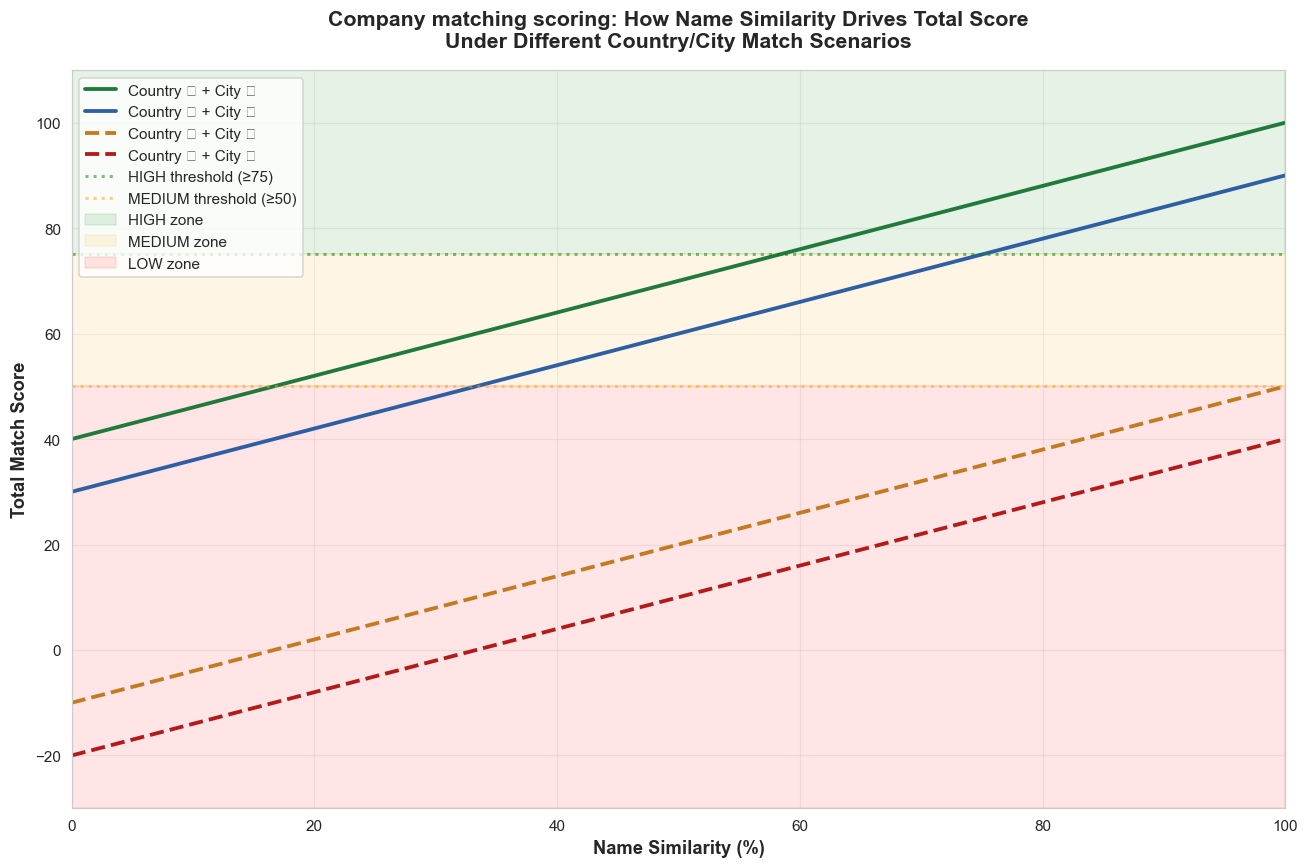

In [130]:

# ═══════════════════════════════════════════════════════════════════════════
# PLOT 1: 2D Line Plot - Cleaner Version
# ═══════════════════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(12, 8))

# Generate name similarity range
name_sim = np.linspace(0, 100, 100)

# Define scenarios with colors
scenarios_2d = [
    ('Country ✓ + City ✓', 30, 10, '#217A3C', '-', 2.5),
    ('Country ✓ + City ✗', 30, 0, '#2E5FA3', '-', 2.5),
    ('Country ✗ + City ✓', -20, 10, '#C47A20', '--', 2.5),
    ('Country ✗ + City ✗', -20, 0, '#B31B1B', '--', 2.5),
]

for label, country, city, color, linestyle, linewidth in scenarios_2d:
    scores = name_sim * 0.60 + country + city
    ax.plot(name_sim, scores, label=label, color=color, 
            linestyle=linestyle, linewidth=linewidth)

# Add threshold lines
ax.axhline(75, color='green', linestyle=':', linewidth=2, alpha=0.5, 
           label='HIGH threshold (≥75)')
ax.axhline(50, color='orange', linestyle=':', linewidth=2, alpha=0.5, 
           label='MEDIUM threshold (≥50)')

# Shade regions
ax.fill_between([0, 100], 75, 110, alpha=0.1, color='green', label='HIGH zone')
ax.fill_between([0, 100], 50, 75, alpha=0.1, color='orange', label='MEDIUM zone')
ax.fill_between([0, 100], -30, 50, alpha=0.1, color='red', label='LOW zone')

# Labels and formatting
ax.set_xlabel('Name Similarity (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Match Score', fontsize=12, fontweight='bold')
ax.set_title('Company matching scoring: How Name Similarity Drives Total Score\nUnder Different Country/City Match Scenarios',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 100)
ax.set_ylim(-30, 110)
ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('scoring_scenarios_2d.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


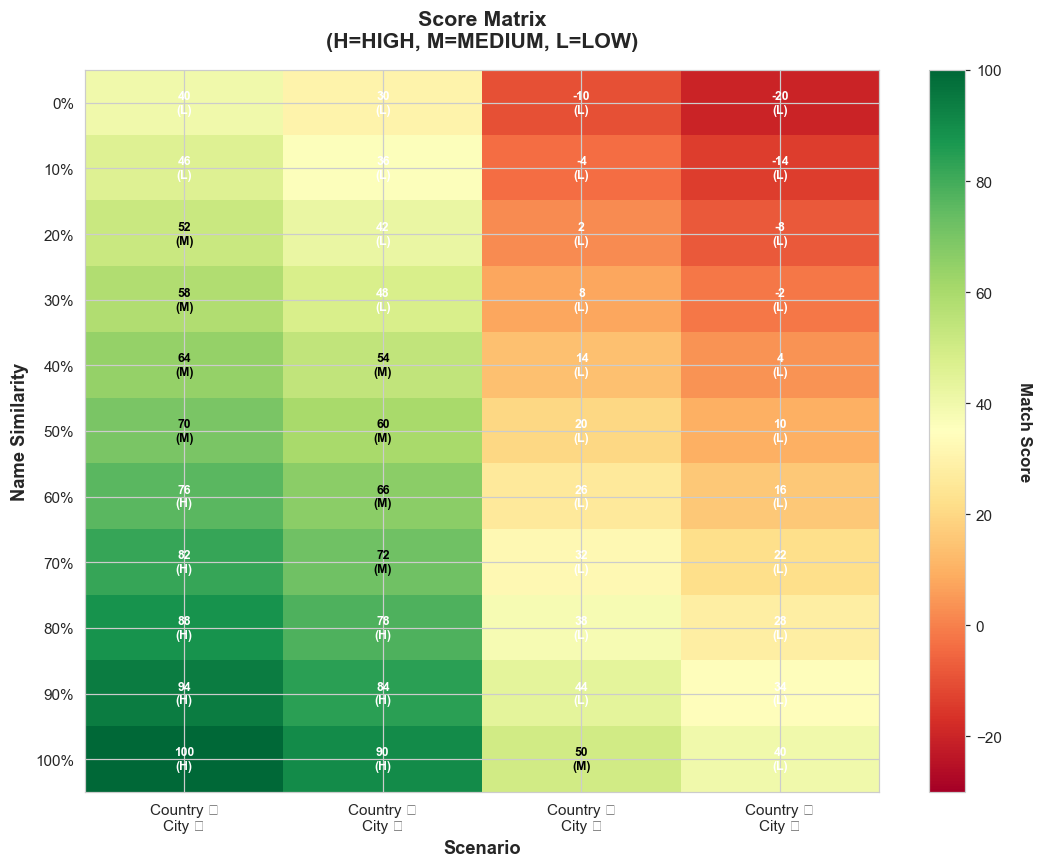

In [131]:
# ═══════════════════════════════════════════════════════════════════════════
# PLOT 2: Heatmap - Score Matrix
# ═══════════════════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(10, 8))

# Create score matrix
# Rows: Name similarity (0-100% in steps of 10)
# Columns: Scenarios (4 country/city combinations)

name_similarities = np.arange(0, 101, 10)
scenario_labels = ['Country ✓\nCity ✓', 'Country ✓\nCity ✗', 
                   'Country ✗\nCity ✓', 'Country ✗\nCity ✗']
scenario_params = [(30, 10), (30, 0), (-20, 10), (-20, 0)]

score_matrix = np.zeros((len(name_similarities), len(scenario_params)))

for i, name_sim in enumerate(name_similarities):
    for j, (country, city) in enumerate(scenario_params):
        score_matrix[i, j] = name_sim * 0.60 + country + city

# Create heatmap
im = ax.imshow(score_matrix, cmap='RdYlGn', aspect='auto', vmin=-30, vmax=100)

# Set ticks
ax.set_xticks(range(len(scenario_labels)))
ax.set_xticklabels(scenario_labels, fontsize=10)
ax.set_yticks(range(len(name_similarities)))
ax.set_yticklabels([f'{int(s)}%' for s in name_similarities], fontsize=10)

# Add text annotations
for i in range(len(name_similarities)):
    for j in range(len(scenario_params)):
        score = score_matrix[i, j]
        
        # Determine confidence tier
        if score >= 75:
            tier = 'H'
            color = 'white'
        elif score >= 50:
            tier = 'M'
            color = 'black'
        else:
            tier = 'L'
            color = 'white'
        
        ax.text(j, i, f'{score:.0f}\n({tier})', ha='center', va='center',
                fontsize=8, fontweight='bold', color=color)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Match Score', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

# Labels
ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Name Similarity', fontsize=12, fontweight='bold')
ax.set_title('Score Matrix\n(H=HIGH, M=MEDIUM, L=LOW)',
             fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('scoring_scenarios_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### 7.5 Resolution - now we tie everything together

For each input we score all candidates, pick the best, apply tie-breaking,
then decide the status:
- **MATCHED** — HIGH or MEDIUM confidence, good data, fresh record
- **REVIEW_NEEDED** — LOW score, too many nulls, or stale data


In [94]:
def resolve(df):
    print('[1/3] Normalizing...')
    for col in df.select_dtypes(include='object').columns:
        df[col] = clean_nulls(df[col])
    df['input_main_country_code'] = df['input_main_country_code'].apply(n_country)
    df['main_country_code']       = df['main_country_code'].apply(n_country)
    df['updated_at']              = pd.to_datetime(df['last_updated_at'], errors='coerce', utc=True)
    print('   done')

    print('[2/3] Resolving...')
    rows = []
    keys = sorted(df['input_row_key'].unique())

    for i, key in enumerate(keys, 1):
        if i % 100 == 0:
            print(f'   {i}/{len(keys)} ({i/len(keys)*100:.0f}%)')
        try:
            cands    = df[df['input_row_key'] == key]
            inp      = cands.iloc[0]
            inp_name = str(inp['input_company_name'])
            inp_cc   = str(inp['input_main_country_code']) if pd.notna(inp['input_main_country_code']) else ''
            inp_city = str(inp['input_main_city'])         if pd.notna(inp['input_main_city'])         else ''

            best_pts, best_cand, best_num, best_sim, best_info = -999.0, None, None, 0.0, {}
            ties = []

            for j, (_, cand) in enumerate(cands.iterrows(), 1):
                pts, nsim, info = score(inp_name, inp_cc, inp_city, cand)
                if pts > best_pts:
                    best_pts, best_cand, best_num, best_sim, best_info = pts, cand, j, nsim, info
                    ties = [j]
                elif pts == best_pts:
                    ties.append(j)

            # Tie-breaking: prefer extracted data, then most recently updated
            if len(ties) > 1:
                pool = cands.iloc[[t - 1 for t in ties]].copy()
                extracted = pool[
                    (pool['revenue_type'] == 'extracted') |
                    (pool['employee_count_type'] == 'extracted')
                ]
                pool = extracted if len(extracted) else pool
                pool['_upd'] = pd.to_datetime(pool['last_updated_at'], errors='coerce', utc=True)
                best_cand = pool.sort_values('_upd', ascending=False).iloc[0]

            # Status
            conf      = tier(best_pts)
            nr        = null_rate(best_cand)
            stale     = is_stale(best_cand)
            reasons   = []
            status    = 'MATCHED' if conf in ('HIGH', 'MEDIUM') else 'REVIEW_NEEDED'
            if conf == 'LOW':                       reasons.append(f'Low score ({best_pts:.1f})')
            if nr >= NULL_THRESH:                   status = 'REVIEW_NEEDED'; reasons.append(f'High null rate ({nr:.0%})')
            if stale:                               status = 'REVIEW_NEEDED'; reasons.append(f'Stale record')

            rows.append({
                'input_row_key': key,
                'input_company_name':    inp_name,
                'input_cc':              inp_cc,
                'input_country':         inp['input_main_country'],
                'input_city':            inp_city,
                'candidate_num':         best_num,
                'match_score':           round(best_pts, 1),
                'name_sim_pct':          round(best_sim, 1),
                'confidence':            conf,
                'status':                status,
                'null_rate_pct':         round(nr * 100, 1),
                'stale':                 stale,
                'veridion_id':           best_cand['veridion_id'],
                'matched_name':          best_cand['company_name'],
                'matched_legal':         best_cand['company_legal_names'],
                'matched_commercial':    best_cand['company_commercial_names'],
                'matched_cc':            best_cand['main_country_code'],
                'matched_country':       best_cand['main_country'],
                'matched_region':        best_cand['main_region'],
                'matched_city':          best_cand['main_city'],
                'matched_postcode':      best_cand['main_postcode'],
                'matched_street':        best_cand['main_street'],
                'matched_lat':           best_cand['main_latitude'],
                'matched_lon':           best_cand['main_longitude'],
                'website':               best_cand['website_url'],
                'phone':                 best_cand['primary_phone'],
                'email':                 best_cand['primary_email'],
                'linkedin':              best_cand['linkedin_url'],
                'sector':                best_cand['main_sector'],
                'industry':              best_cand['main_industry'],
                'naics_code':            best_cand['naics_2022_primary_code'],
                'naics_label':           best_cand['naics_2022_primary_label'],
                'revenue':               best_cand['revenue'],
                'revenue_type':          best_cand['revenue_type'],
                'employees':             best_cand['employee_count'],
                'employee_type':         best_cand['employee_count_type'],
                'year_founded':          best_cand['year_founded'],
                'company_type':          best_cand['company_type'],
                'n_locations':           best_cand['num_locations'],
                'last_updated':          best_cand['last_updated_at'],
                'country_signal':        best_info.get('country', ''),
                'city_signal':           best_info.get('city', ''),
                'review_reasons':        '; '.join(reasons),
            })

        except Exception as e:
            print(f'   ERROR key={key}: {e}')
            rows.append({'input_row_key': key, 'status': 'ERROR',
                         'confidence': 'LOW', 'review_reasons': str(e)})

    out = pd.DataFrame(rows)
    print(f'[3/3] Done — {len(out):,} inputs resolved')
    return out


## 8. Results

Run the resolution, print a summary, and inspect the review queue.


In [95]:
results = resolve(df.copy())


[1/3] Normalizing...
   done
[2/3] Resolving...
   100/592 (17%)
   200/592 (34%)
   300/592 (51%)
   400/592 (68%)
   500/592 (84%)
[3/3] Done — 592 inputs resolved


In [96]:
total   = len(results)
matched = (results['status'] == 'MATCHED').sum()
review  = (results['status'] == 'REVIEW_NEEDED').sum()
errors  = (results['status'] == 'ERROR').sum()

print(f'Total inputs:     {total:,}')
print(f'Matched:          {matched:,}  ({matched/total*100:.1f}%)')
print(f'Review needed:    {review:,}  ({review/total*100:.1f}%)')
if errors: print(f'Errors:           {errors:,}')

print('\nConfidence dist:')
for t in ('HIGH','MEDIUM','LOW'):
    n = (results['confidence'] == t).sum()
    print(f'  {t:<8} {n:,}  ({n/total*100:.1f}%)')

print('\nFlagged for:')
print(f'  Stale data:     {results["stale"].sum():,}')
print(f'  High null rate: {(results["null_rate_pct"] >= NULL_THRESH*100).sum():,}')

print(f'\nScore stats  mean={results["match_score"].mean():.1f}  '
      f'median={results["match_score"].median():.1f}  '
      f'min={results["match_score"].min():.1f}  '
      f'max={results["match_score"].max():.1f}')


Total inputs:     592
Matched:          530  (89.5%)
Review needed:    62  (10.5%)

Confidence dist:
  HIGH     436  (73.6%)
  MEDIUM   143  (24.2%)
  LOW      13  (2.2%)

Flagged for:
  Stale data:     1
  High null rate: 53

Score stats  mean=84.4  median=90.0  min=6.7  max=100.0


In [97]:
# Flag rows that also need web research ( also medium confidence with country mismatch)
web_research = results[
    (results['confidence'] == 'LOW') |
    ((results['confidence'] == 'MEDIUM') & (results['input_cc'] != results['matched_cc']))
]
print(f'{len(web_research)} rows flagged for web research')

31 rows flagged for web research


### Nice plot with result distribution

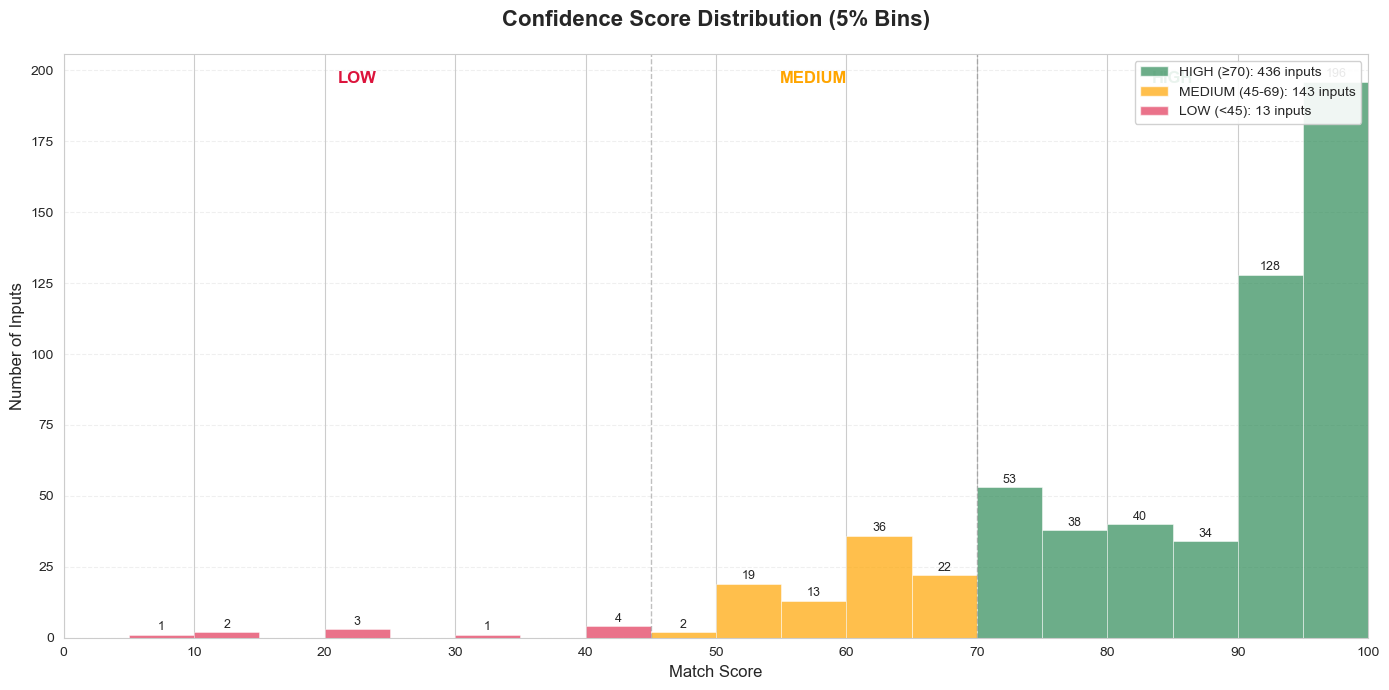

In [98]:
# Define bins from 0 to 100 (5% increments)
bins = np.arange(0, 105, 5)
bin_labels = [f"{i}-{i+5}" for i in range(0, 100, 5)]

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot histogram with 5% bins
n, bins, patches = ax.hist(results['match_score'], bins=bins, 
                           edgecolor='white', linewidth=0.5, alpha=0.8)

# Color each bar based on the confidence tier of its score range
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    
    if bin_center >= 70:
        patch.set_facecolor('#2E8B57')  # HIGH - green
        patch.set_alpha(0.7)
    elif bin_center >= 45:
        patch.set_facecolor('#FFA500')  # MEDIUM - orange
        patch.set_alpha(0.7)
    else:
        patch.set_facecolor('#DC143C')  # LOW - crimson
        patch.set_alpha(0.6)

# Add value labels on top of bars
for i, (patch, count) in enumerate(zip(patches, n)):
    if count > 0:
        height = patch.get_height()
        ax.text(patch.get_x() + patch.get_width()/2., height + 0.5,
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

# Add tier separator lines
ax.axvline(x=45, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=70, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Add tier labels
ax.text(22.5, ax.get_ylim()[1]*0.95, 'LOW', 
        ha='center', fontsize=12, fontweight='bold', color='#DC143C')
ax.text(57.5, ax.get_ylim()[1]*0.95, 'MEDIUM', 
        ha='center', fontsize=12, fontweight='bold', color='#FFA500')
ax.text(85, ax.get_ylim()[1]*0.95, 'HIGH', 
        ha='center', fontsize=12, fontweight='bold', color='#2E8B57')

# Customize the plot
ax.set_title('Confidence Score Distribution (5% Bins)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Match Score', fontsize=12)
ax.set_ylabel('Number of Inputs', fontsize=12)
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E8B57', alpha=0.7, label=f'HIGH (≥70): {len(results[results["confidence"]=="HIGH"])} inputs'),
    Patch(facecolor='#FFA500', alpha=0.7, label=f'MEDIUM (45-69): {len(results[results["confidence"]=="MEDIUM"])} inputs'),
    Patch(facecolor='#DC143C', alpha=0.6, label=f'LOW (<45): {len(results[results["confidence"]=="LOW"])} inputs')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.savefig('confidence_distribution_5percent_bins.png', dpi=300, bbox_inches='tight')
plt.show()


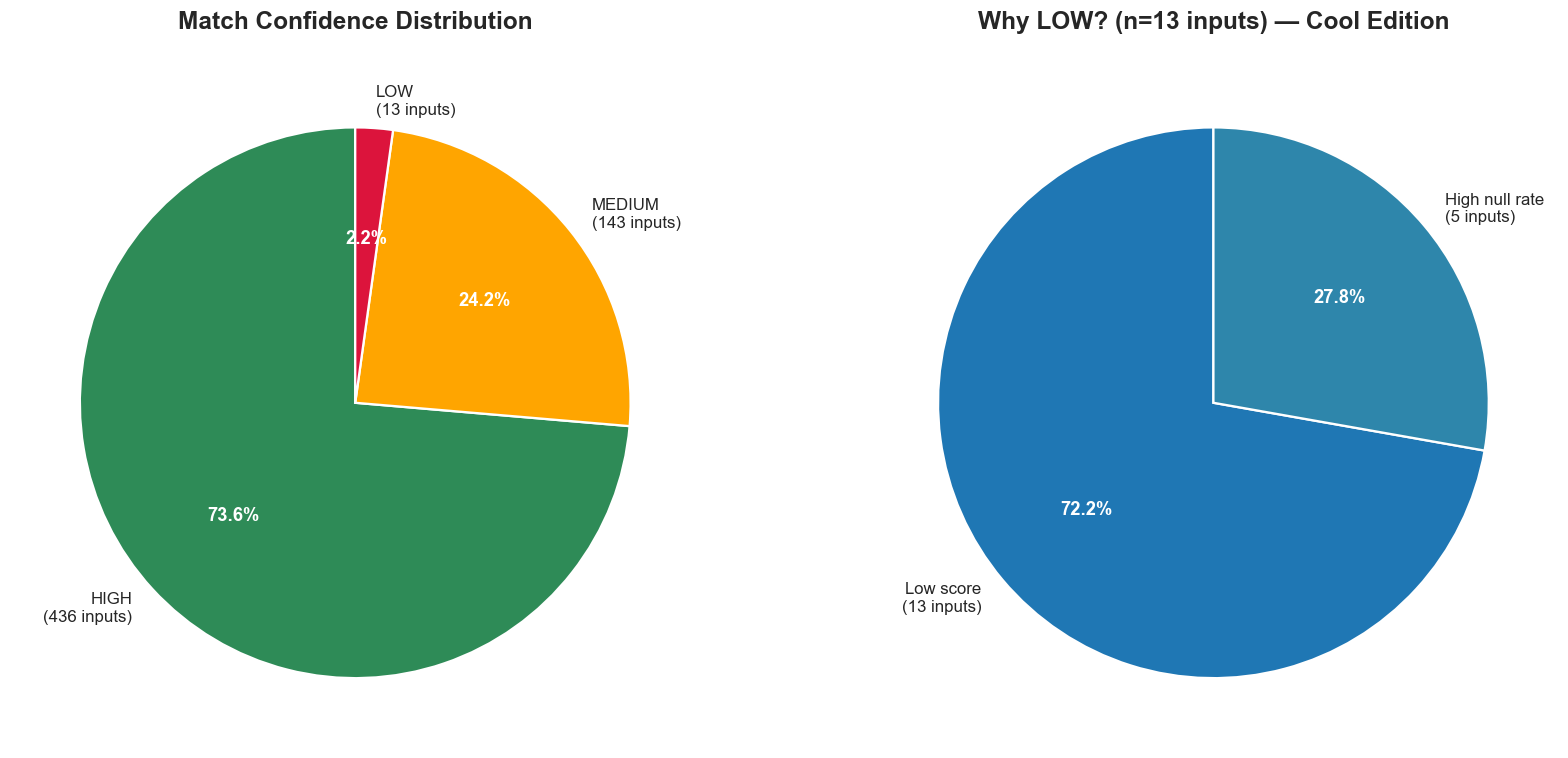

In [133]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Colors
colors = {
    'HIGH': '#2E8B57',    # green
    'MEDIUM': '#FFA500',  # orange
    'LOW': '#DC143C',     # red
}

# Cool colors for LOW breakdown (blues, purples, teals)
cool_colors = ['#1f77b4', '#2E86AB', '#5D3FD3', '#008080', '#6A5ACD']

# ============================================================================
# PIE CHART 1: CONFIDENCE DISTRIBUTION
# ============================================================================
conf_counts = results['confidence'].value_counts()
conf_pcts = results['confidence'].value_counts(normalize=True) * 100

wedges1, texts1, autotexts1 = axes[0].pie(
    conf_counts.values,
    labels=[f"{tier}\n({count} inputs)" for tier, count in zip(conf_counts.index, conf_counts.values)],
    autopct='%1.1f%%',
    colors=[colors.get(x, '#808080') for x in conf_counts.index],
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 11}
)

# Make percentage text bold and white
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

axes[0].set_title('Match Confidence Distribution', fontsize=16, fontweight='bold', pad=20)


# ============================================================================
# PIE CHART 2: LOW TIER BREAKDOWN - COOL COLORS EDITION
# ============================================================================

# Filter LOW confidence inputs
low_df = results[results['confidence'] == 'LOW'].copy()

if len(low_df) > 0:
    # Parse review reasons
    all_reasons = []
    for reasons in low_df['review_reasons'].dropna():
        # Split by semicolon and clean up
        for r in reasons.split(';'):
            r = r.strip()
            if r:
                all_reasons.append(r)
    
    # Count reason frequencies
    reason_counts = {}
    for r in all_reasons:
        # Extract the main reason (e.g., "Low score (45.2)" -> "Low score")
        main_reason = r.split('(')[0].strip()
        reason_counts[main_reason] = reason_counts.get(main_reason, 0) + 1
    
    # Convert to Series for plotting
    reason_series = pd.Series(reason_counts)
    
    # Only show reasons that appear at least once
    reason_series = reason_series[reason_series > 0]
    
    # Pie chart of reasons with cool colors
    wedges2, texts2, autotexts2 = axes[1].pie(
        reason_series.values,
        labels=[f"{reason}\n({count} inputs)" for reason, count in zip(reason_series.index, reason_series.values)],
        autopct='%1.1f%%',
        colors=cool_colors[:len(reason_series)],  # cool blues/purples
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        textprops={'fontsize': 11}
    )
    
    # Make percentage text bold and white
    for autotext in autotexts2:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    axes[1].set_title(f'Why LOW? (n={len(low_df)} inputs) — Cool Edition', fontsize=16, fontweight='bold', pad=20)
    
else:
    axes[1].text(0.5, 0.5, 'No LOW confidence inputs! 🎉', 
                 ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].set_title('LOW Tier Analysis', fontsize=16, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('confidence_pie_charts_cool.png', dpi=300, bbox_inches='tight')
plt.show()

### Review queue

Every REVIEW_NEEDED case printed in a readable format — ready for the analyst to action.

In [100]:
review_cases = results[results['status'] == 'REVIEW_NEEDED']

if len(review_cases) == 0:
    print('All inputs matched with sufficient confidence — nothing to review!')
else:
    review_cases.to_csv('review_cases.csv', index=False)
print(f"Saved {len(review_cases)} review cases to 'review_cases.csv'")

Saved 62 review cases to 'review_cases.csv'


In [101]:
review_df = pd.read_csv('review_cases.csv')
review_df.head()

,input_row_key,input_company_name,input_cc,input_country,input_city,candidate_num,match_score,name_sim_pct,confidence,status,...,revenue_type,employees,employee_type,year_founded,company_type,n_locations,last_updated,country_signal,city_signal,review_reasons
0,8,a. t. kearney pte. ltd,SG,singapore,NaN,2,48.0,80.0,LOW,REVIEW_NEEDED,...,NaN,NaN,NaN,NaN,private,NaN,2025-02-09t07:01:53.000z,NaN,NaN,Low score (48.0); High null rate (75%)
1,13,"acome xintai cables co., ltd.",CN,china,xintai,1,90.0,100.0,HIGH,REVIEW_NEEDED,...,NaN,NaN,NaN,NaN,NaN,1.0,2025-03-31t09:32:36.033z,MATCH +30,NO MATCH (xintai ≠ chaoyang),High null rate (62%)
2,19,advanced network solutions sdn bhd,MY,malaysia,shah alam,5,88.0,80.0,HIGH,REVIEW_NEEDED,...,NaN,NaN,NaN,NaN,NaN,1.0,2025-04-19t23:06:45.687z,MATCH +30,MATCH +10,High null rate (62%)
3,26,aktieselskabet rodovre centrum,DK,denmark,rødovre municipality,2,98.0,96.7,HIGH,REVIEW_NEEDED,...,NaN,NaN,NaN,NaN,NaN,1.0,2025-04-20t08:33:29.456z,MATCH +30,MATCH +10,High null rate (62%)
4,32,amdocs development limited,CY,cyprus,limassol,3,30.0,50.0,LOW,REVIEW_NEEDED,...,NaN,NaN,NaN,NaN,private,NaN,2024-12-07t06:36:59.000z,NaN,NaN,Low score (30.0); High null rate (75%)


In [102]:
# Flag rows that also need web research
web_research = results[
    (results['confidence'] == 'LOW') |
    ((results['confidence'] == 'MEDIUM') & (results['input_cc'] != results['matched_cc']))
]
print(f'{len(web_research)} rows flagged for web research')
web_research[['input_row_key','input_company_name','matched_name','match_score','review_reasons']]  # renders as table in Jupyter


31 rows flagged for web research


,input_row_key,input_company_name,matched_name,match_score,review_reasons
3,3,3 step it as,3 step it a/s.,50.0,
8,8,a. t. kearney pte. ltd,atkearney,48.0,Low score (48.0); High null rate (75%)
32,32,amdocs development limited,amdocs,30.0,Low score (30.0); High null rate (75%)
33,33,"american express europe denmark, filial af ame...",american steakhouse,43.8,Low score (43.8)
35,35,analysys mason as,analysys mason,50.0,
40,40,anritsu a/s,anritsu,60.0,High null rate (75%)
60,60,aviat networks japan llc,aviat networks,49.4,Low score (49.4); High null rate (75%)
66,66,"bb connect co.,ltd.",bb connect latam,60.0,High null rate (62%)
162,162,egencia sweden ab,egencia switzerland,23.6,Low score (23.6)
208,208,google cloud emea limited,doubleclick,50.0,


### Save outputs

In [103]:
web_research.to_csv('web_research_needed.csv', index=False)
print('Saved: entity_resolution_results.csv')
print('Saved: web_research_needed.csv')


Saved: entity_resolution_results.csv
Saved: web_research_needed.csv
